<a href="https://colab.research.google.com/github/jonmontg/data_analysis/blob/main/car_prices_dirty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Used Car Price Prediction

##Setup

In [ ]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats import ttest_ind
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import tree
from decimal import Decimal
from re import sub
import datetime
import math
import re

In [ ]:
df = pd.read_csv("used_cars.csv")

In [ ]:
def to_float(x):
  return int(sub(r'[^\d]', '', x))

##Exploring the data

In [ ]:
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


In [ ]:
df.isna().sum()

brand             0
model             0
model_year        0
milage            0
fuel_type       170
engine            0
transmission      0
ext_col           0
int_col           0
accident        113
clean_title     596
price             0
dtype: int64

###Price

In [ ]:
df.price

0        $10,300
1        $38,005
2        $54,598
3        $15,500
4        $34,999
          ...   
4004    $349,950
4005     $53,900
4006     $90,998
4007     $62,999
4008     $40,000
Name: price, Length: 4009, dtype: object

Let's convert the price values to integers.

In [ ]:
df.price = df.price.map(to_float)

In [ ]:
df.price

0        10300
1        38005
2        54598
3        15500
4        34999
         ...  
4004    349950
4005     53900
4006     90998
4007     62999
4008     40000
Name: price, Length: 4009, dtype: int64

In [ ]:
df.price.describe()

count    4.009000e+03
mean     4.455319e+04
std      7.871064e+04
min      2.000000e+03
25%      1.720000e+04
50%      3.100000e+04
75%      4.999000e+04
max      2.954083e+06
Name: price, dtype: float64

In [ ]:
df.price.median()

31000.0

The data show a rightward skew.

<Axes: xlabel='price', ylabel='brand'>

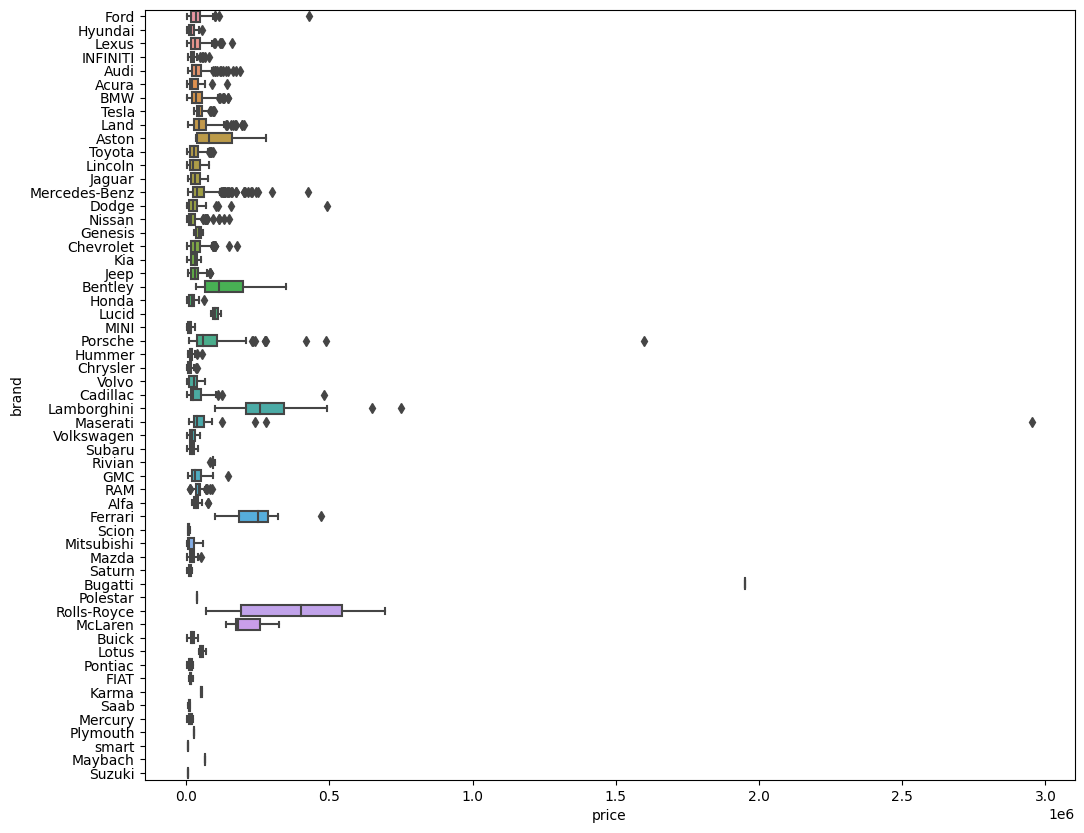

In [ ]:
plt.figure(figsize=(12,10))
sns.boxplot(data=df, x="price", y="brand")

The data contain some extreme outliers. Let's remove them to clean things up.

In [ ]:
Q1 = df.quantile(0.25, numeric_only=True)
Q3 = df.quantile(0.75, numeric_only=True)
IQR = Q3-Q1
df = df[~((df.lt(Q1-1.5*IQR))| (df.gt(Q3+1.5*IQR))).any(axis=1)]

<Axes: xlabel='price', ylabel='brand'>

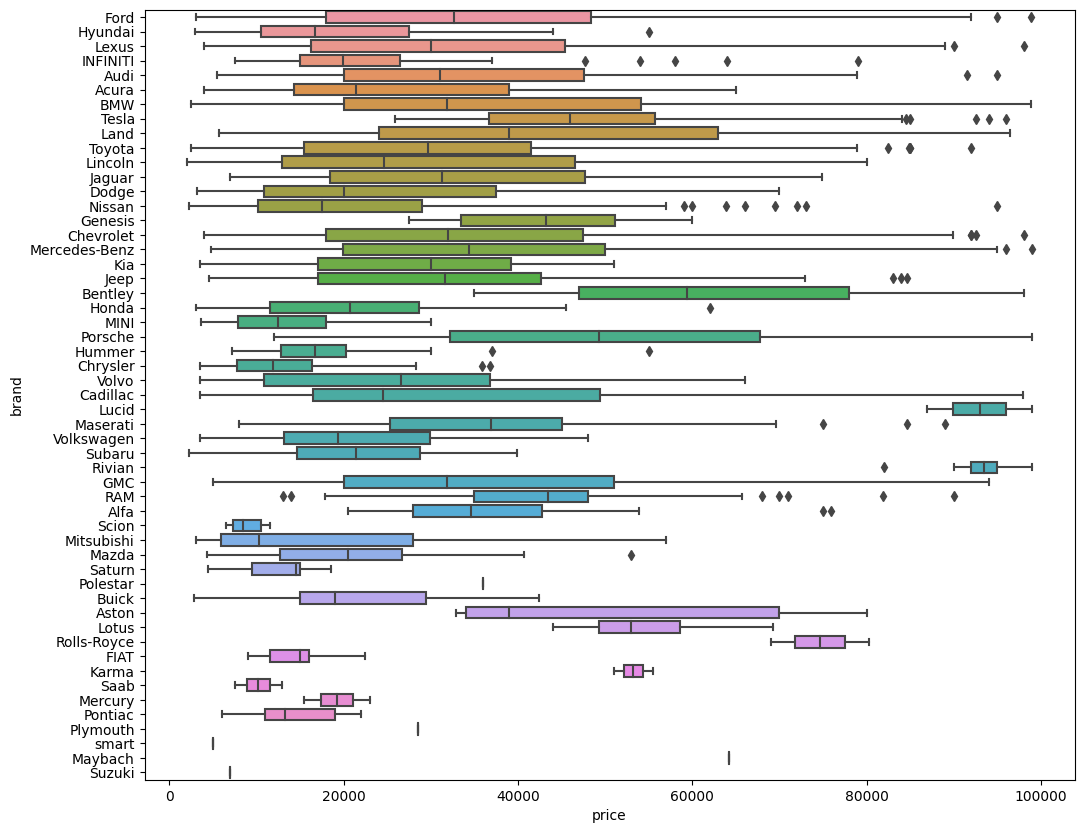

In [ ]:
plt.figure(figsize=(12,10))
sns.boxplot(data=df, x="price", y="brand")

In [ ]:
df.price.describe()

count     3699.000000
mean     33838.981617
std      21292.918498
min       2000.000000
25%      16999.500000
50%      29994.000000
75%      45950.000000
max      99000.000000
Name: price, dtype: float64

In [ ]:
df.price.median()

29994.0

###Brand

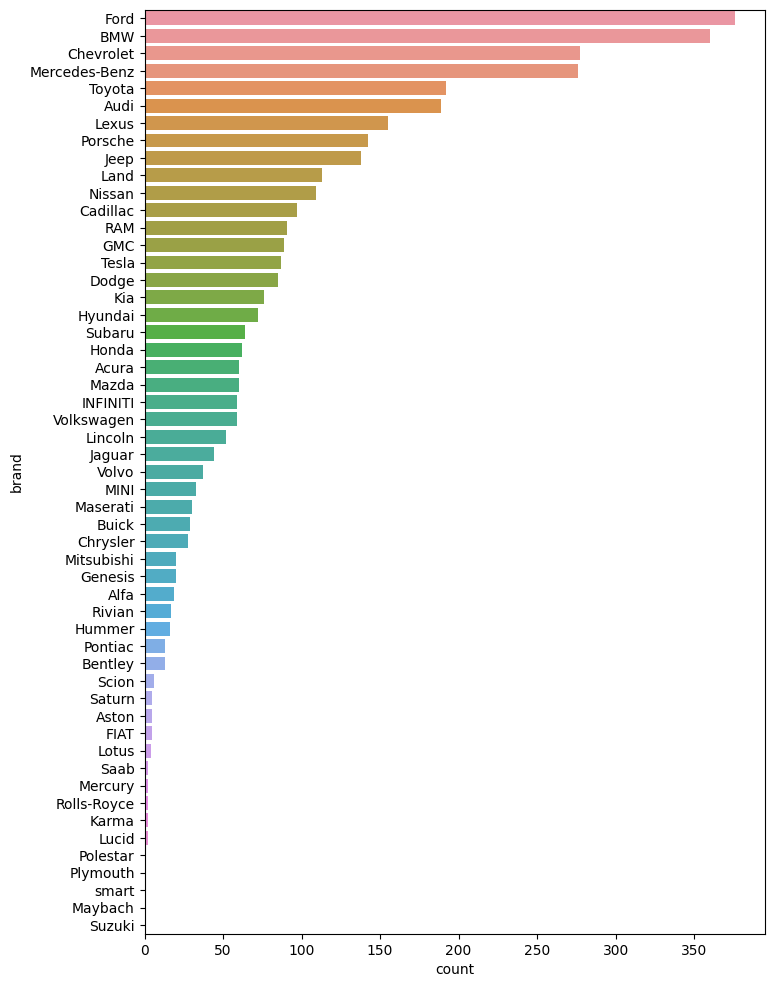

In [ ]:
plt.figure(figsize=(8,12))
sns.countplot(data=df, y="brand", order = df["brand"].value_counts().index)
plt.show()

###Model

In [ ]:
df.model.describe()

count        3699
unique       1756
top       M3 Base
freq           29
Name: model, dtype: object

###Model Year

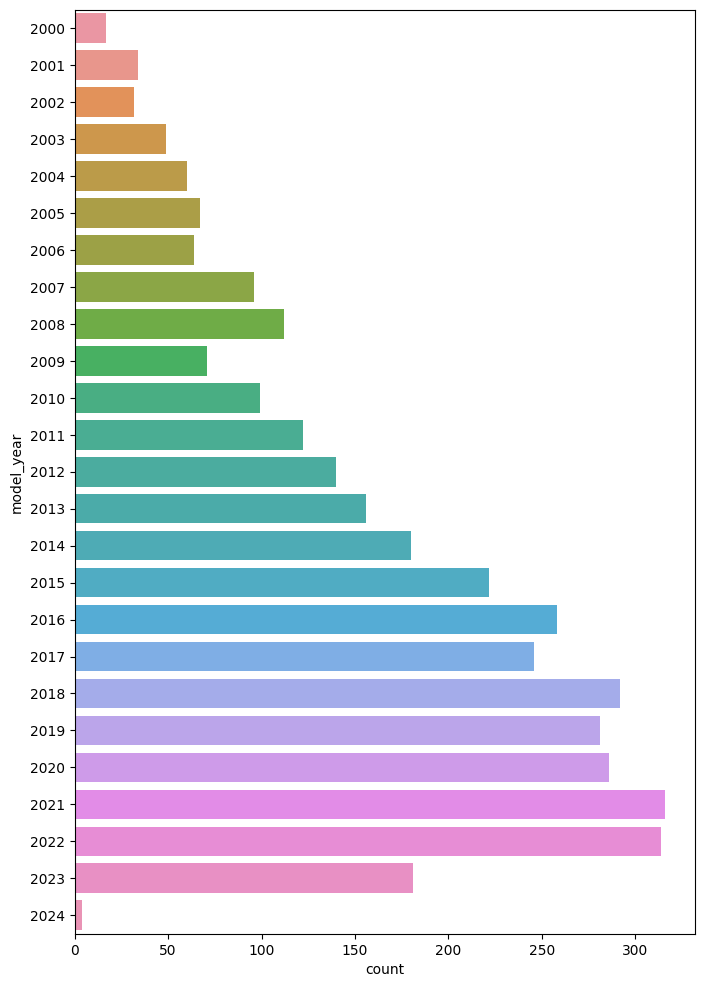

In [ ]:
plt.figure(figsize=(8,12))
sns.countplot(data=df, y="model_year")
plt.show()

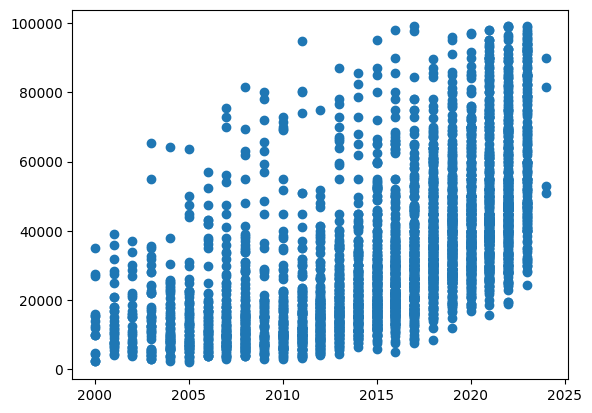

In [ ]:
plt.scatter(df.model_year, df.price)

###Milage

In [ ]:
df.milage = df.milage.map(to_float)

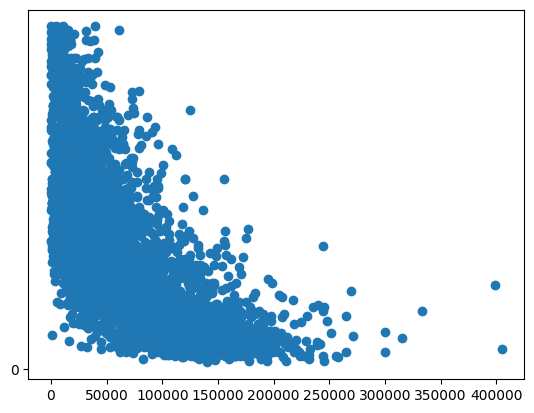

In [ ]:
plt.scatter(df.milage, df.price)
plt.yticks(np.arange(0, df.price.max(), 200000))
plt.show()

###Fuel Type

In [ ]:
df.fuel_type.describe()

count         3536
unique           7
top       Gasoline
freq          3055
Name: fuel_type, dtype: object

In [ ]:
df.fuel_type.unique()

array(['E85 Flex Fuel', 'Gasoline', 'Hybrid', nan, 'Diesel',
       'Plug-In Hybrid', '–', 'not supported'], dtype=object)

There are a few categories that indicate a missing value.

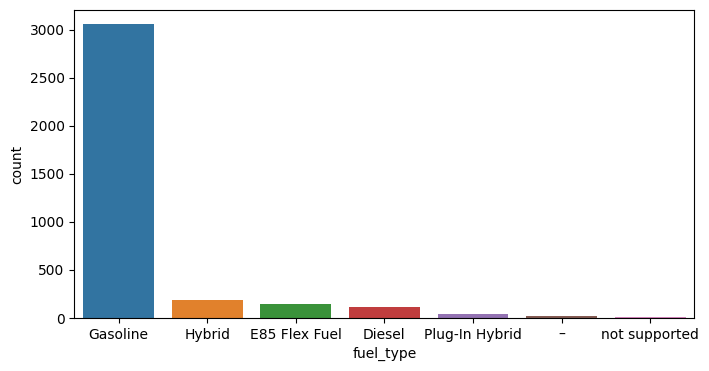

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x="fuel_type", order = df["fuel_type"].value_counts().index)
plt.show()

###Engine

In [ ]:
df.engine.describe()

count                                             3699
unique                                            1038
top       355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel
freq                                                48
Name: engine, dtype: object

###Transmission

In [ ]:
df.transmission.unique()

array(['6-Speed A/T', '8-Speed Automatic', 'Automatic', '7-Speed A/T',
       'F', 'A/T', 'Transmission w/Dual Shift Mode', '6-Speed M/T',
       '8-Speed A/T', '10-Speed A/T', '9-Speed A/T', '5-Speed A/T',
       'Automatic CVT', 'CVT-F', '1-Speed A/T', 'M/T',
       '6-Speed Automatic with Auto-Shift', '10-Speed Automatic',
       'CVT Transmission', '4-Speed A/T', '6-Speed Automatic',
       '4-Speed Automatic', '7-Speed M/T',
       '8-Speed Automatic with Auto-Shift', '5-Speed Automatic',
       '8-SPEED AT', '9-Speed Automatic', '5-Speed M/T', '6-Speed Manual',
       'Variable', '1-Speed Automatic', '2', 'Automatic, 9-Spd 9G-Tronic',
       'Automatic, 8-Spd',
       'Automatic, 8-Spd Sport w/Sport & Manual Modes',
       'Auto, 6-Spd w/CmdShft', 'Transmission Overdrive Switch',
       '7-Speed Automatic', 'Automatic, 8-Spd PDK Dual-Clutch',
       'Automatic, 8-Spd M STEPTRONIC w/Drivelogic, Sport & Manual Modes',
       '7-Speed Automatic with Auto-Shift', '6-Speed',
       'S

###Exterior Color

In [ ]:
df.ext_col.unique()

array(['Black', 'Moonlight Cloud', 'Blue', 'Glacier White Metallic',
       'Silver', 'Green', 'Fuji White', 'Yellow', 'White', 'Purple',
       'Iconic Silver Metallic', 'Gray', 'Mythos Black Metallic', 'Red',
       'Gold', 'Lunar Silver Metallic', 'Mountain Air Metallic',
       'Caspian Blue', '–', 'Alpine White', 'Horizon Blue',
       'Granite Crystal Clearcoat Metallic', 'Orange', 'Beige',
       'Atomic Silver', 'Summit White', 'Imperial Blue Metallic',
       'Magnetic Gray Clearcoat', 'Bright White Clearcoat',
       'Typhoon Gray', 'Crystal Black Silica', 'Arctic Gray Metallic',
       'Selenite Grey Metallic', 'Ultra Black', 'Lunare White Metallic',
       'Hyper Red', 'Vik Black', 'Pacific Blue Metallic',
       'Obsidian Black Metallic', 'Silver Ice Metallic',
       'Sonic Silver Metallic', 'Apex Blue', 'Go Mango!',
       'Ingot Silver Metallic', 'Midnight Black Metallic',
       'Black Clearcoat', 'Thunder Gray', 'Verde', 'Wind Chill Pearl',
       'Mythos Black', 'Pat

###Interior Color

In [ ]:
df.int_col.unique()

array(['Black', 'Gray', 'Ebony.', 'Green', 'Pimento / Ebony', 'Brown',
       '–', 'Beige', 'Jet Black', 'Light Gray', 'Anthracite', 'Red',
       'Blue', 'Charcoal', 'Rioja Red', 'Canberra Beige/Black', 'White',
       'Roast', 'Ivory / Ebony', 'Silk Beige/Black', 'Medium Pewter',
       'Ice', 'Obsidian Black', 'Ebony', 'Orchid', 'Graphite',
       'Tan/Ebony', 'Cappuccino', 'Nero', 'Orange', 'BLACK', 'Black Onyx',
       'Nougat Brown', 'Titan Black', 'Oyster W/Contrast', 'Silver',
       'Macchiato Beige/Black', 'Sand Beige', 'Navy Pier', 'WHITE',
       'Parchment.', 'Sarder Brown', 'Cloud', 'Espresso', 'Mesa',
       'Whisper Beige', 'Medium Dark Slate', 'Gold', 'Camel Leather',
       'Tupelo', 'Parchment', 'Global Black', 'Titan Black / Quarzit',
       'Mocha', 'Medium Light Camel', 'Black / Saddle', 'Ash',
       'Ebony / Pimento', 'Blk', 'Tan', 'Mistral Gray / Raven',
       'Graystone', 'Satin Black', 'Sandstone', 'Medium Stone', 'ORANGE',
       'Pimento Red w/Ebony', 'Mac

###Accident

In [ ]:
df.accident.unique()

array(['At least 1 accident or damage reported', 'None reported', nan],
      dtype=object)

###Clean Title

In [ ]:
df.clean_title.unique()

array(['Yes', nan], dtype=object)

##Preprocessing

In [ ]:
def one_hot_encode(data, column, values=None):
  unique = data[column].unique() if values is None else data[column].unique()
  i = 0
  for val in unique:
    col = data[column].map(lambda x: 1 if x == val else 0)
    data.insert(len(df.columns), "%s-%s" % (column, val), col)
    i += 1
    if i > 15:
      data = df.copy()
      i = 0
  return data.drop(columns=column)

###Model

One-hot encoding the model makes the dataframe very wide, but it improves the performance of the regressions. Without the model column, the models were performing with ME~16500. The random forest performs better with this column: ~13393

In [ ]:
df = one_hot_encode(df, "model")
df.head()

,brand,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,...,model-Martin DB7 Vantage Volante,model-CT 200h Base,model-X3 xDrive28i,model-EcoSport SES,model-SX4 Base,model-F-PACE 35t Premium,model-Tundra Grade,model-Prius Two,model-M240 i xDrive,model-Escalade Base
0,Ford,2013,51000,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,...,0,0,0,0,0,0,0,0,0,0
1,Hyundai,2021,34742,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,...,0,0,0,0,0,0,0,0,0,0
2,Lexus,2022,22372,Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,...,0,0,0,0,0,0,0,0,0,0
3,INFINITI,2015,88900,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,...,0,0,0,0,0,0,0,0,0,0
4,Audi,2021,9835,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,...,0,0,0,0,0,0,0,0,0,0


###Brand

In [ ]:
df = one_hot_encode(df, "brand")
df.head()

,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,...,brand-Jaguar,brand-Dodge,brand-Nissan,brand-Genesis,brand-Chevrolet,brand-Suzuki,brand-Maybach,brand-smart,brand-Plymouth,brand-Pontiac
0,2013,51000,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,10300,...,0,0,0,0,0,0,0,0,0,0
1,2021,34742,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005,...,0,0,0,0,0,0,0,0,0,0
2,2022,22372,Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,54598,...,0,0,0,0,0,0,0,0,0,0
3,2015,88900,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,15500,...,0,0,0,0,0,0,0,0,0,0
4,2021,9835,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,34999,...,0,0,0,0,0,0,0,0,0,0


###Engine

In [ ]:
df.engine.describe()

count                                             3699
unique                                            1038
top       355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel
freq                                                48
Name: engine, dtype: object

In [ ]:
def extract_horsepower(x):
  hp = re.search("[\d\.]+ ?HP", x, re.IGNORECASE)
  if hp is None:
    return 0
  return float(re.search("[\d\.]*", hp.group(0)).group(0))

In [ ]:
df["horsepower"] = df.engine.map(extract_horsepower)

In [ ]:
def extract_displacement(x):
  displacement = re.search("[\d\.]+ ?L", x, re.IGNORECASE)
  if displacement is None:
    return 0
  return float(re.search("[\d\.]*", displacement.group(0)).group(0))


In [ ]:
df.engine = df.engine.map(extract_displacement)

In [ ]:
df = df.drop(columns="engine")

###Fuel Type

In [ ]:
df.fuel_type = df.fuel_type.map(
    {"-": float("nan"),
     "not supported": float("nan"),
     "E85 Flex Fuel": "E85 Flex Fuel",
     "Gasoline": "Gasoline",
     "Hybrid": "Hybrid",
     "Diesel": "Diesel",
     "Plug-In Hybrid": "Plug-In Hybrid"})

In [ ]:
df = one_hot_encode(df, "fuel_type", filter(lambda x: not type(x) == str and not math.isnan(x), df.fuel_type.unique()))
df.head()

,model_year,milage,transmission,ext_col,int_col,accident,clean_title,price,model-Utility Police Interceptor Base,model-Palisade SEL,...,brand-smart,brand-Plymouth,brand-Pontiac,horsepower,fuel_type-E85 Flex Fuel,fuel_type-Gasoline,fuel_type-Hybrid,fuel_type-nan,fuel_type-Diesel,fuel_type-Plug-In Hybrid
0,2013,51000,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,10300,1,0,...,0,0,0,300.0,1,0,0,0,0,0
1,2021,34742,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005,0,1,...,0,0,0,0.0,0,1,0,0,0,0
2,2022,22372,Automatic,Blue,Black,None reported,NaN,54598,0,0,...,0,0,0,0.0,0,1,0,0,0,0
3,2015,88900,7-Speed A/T,Black,Black,None reported,Yes,15500,0,0,...,0,0,0,354.0,0,0,1,0,0,0
4,2021,9835,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,34999,0,0,...,0,0,0,0.0,0,1,0,0,0,0


###Model Year

Age is a better metric than model year.

In [ ]:
current_year = datetime.date.today().year
df["age"] = df.model_year.map(lambda x: current_year - x)
df = df.drop(columns="model_year")
df.head()

,milage,transmission,ext_col,int_col,accident,clean_title,price,model-Utility Police Interceptor Base,model-Palisade SEL,model-RX 350 RX 350,...,brand-Plymouth,brand-Pontiac,horsepower,fuel_type-E85 Flex Fuel,fuel_type-Gasoline,fuel_type-Hybrid,fuel_type-nan,fuel_type-Diesel,fuel_type-Plug-In Hybrid,age
0,51000,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,10300,1,0,0,...,0,0,300.0,1,0,0,0,0,0,10
1,34742,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005,0,1,0,...,0,0,0.0,0,1,0,0,0,0,2
2,22372,Automatic,Blue,Black,None reported,NaN,54598,0,0,1,...,0,0,0.0,0,1,0,0,0,0,1
3,88900,7-Speed A/T,Black,Black,None reported,Yes,15500,0,0,0,...,0,0,354.0,0,0,1,0,0,0,8
4,9835,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,34999,0,0,0,...,0,0,0.0,0,1,0,0,0,0,2


###Accident Record

In [ ]:
df["missing_accident_record"] = df.accident.map(lambda x: 1 if not type(x) == str and math.isnan(x) else 0)
df.accident = df.accident.map(lambda x: 1 if x == "At least 1 accident or damage reported" else 0)

###Interior Color

In [ ]:
df = df.drop(columns="int_col")

###Exterior Color

In [ ]:
df = df.drop(columns="ext_col")

###Clean Title

In [ ]:
df.clean_title = df.clean_title.map(lambda x: 1 if x == "Yes" else 0)

###Transmission

Let's simplify the data to manual or automatic.

In [ ]:
def map_transmission(x):
  if re.search("(A\/T|AT|Automatic|Dual Shift Mode|CVT-F|Variable|9G-Tronic|Auto)", x):
    return "automatic"
  elif re.search("Manual|M", x):
    return "manual"
  else:
    return "unknown"

In [ ]:
df.transmission = df.transmission.map(map_transmission)

Then let's one-hot encode the transmission type.

In [ ]:
df = one_hot_encode(df, "transmission")
df.head()

,milage,accident,clean_title,price,model-Utility Police Interceptor Base,model-Palisade SEL,model-RX 350 RX 350,model-Q50 Hybrid Sport,model-Q3 45 S line Premium Plus,model-ILX 2.4L,...,fuel_type-Gasoline,fuel_type-Hybrid,fuel_type-nan,fuel_type-Diesel,fuel_type-Plug-In Hybrid,age,missing_accident_record,transmission-automatic,transmission-unknown,transmission-manual
0,51000,1,1,10300,1,0,0,0,0,0,...,0,0,0,0,0,10,0,1,0,0
1,34742,1,1,38005,0,1,0,0,0,0,...,1,0,0,0,0,2,0,1,0,0
2,22372,0,0,54598,0,0,1,0,0,0,...,1,0,0,0,0,1,0,1,0,0
3,88900,0,1,15500,0,0,0,1,0,0,...,0,1,0,0,0,8,0,1,0,0
4,9835,0,0,34999,0,0,0,0,1,0,...,1,0,0,0,0,2,0,1,0,0


##Analysis

In [ ]:
def analyze_model(model, train_x, train_y, test_x, test_y):
  model.fit(train_x, train_y)
  pred = model.predict(test_x)
  print("Mean Error: %f" % math.sqrt(mean_squared_error(test_y, pred)))
  residuals = pred-test_y
  plt.figure(figsize=(6,2))
  sns.boxplot(data=residuals, orient="h").set(title="Residuals")

In [ ]:
df.shape

(3699, 65)

In [ ]:
df.isna().sum()

milage                                   0
accident                                 0
clean_title                              0
price                                    0
model-Utility Police Interceptor Base    0
                                        ..
age                                      0
missing_accident_record                  0
transmission-automatic                   0
transmission-unknown                     0
transmission-manual                      0
Length: 65, dtype: int64

In [ ]:
x = df.loc[:, df.columns != "price"]
y = df["price"].values

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=1)

###Bayesian Ridge Regression

Mean Error: 12577.876116


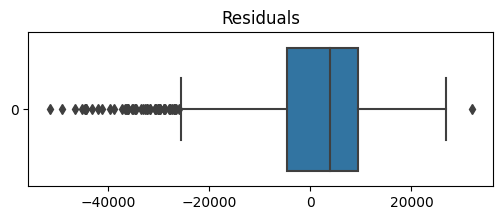

In [ ]:
analyze_model(linear_model.BayesianRidge(), train_x, train_y, test_x, test_y)

Mean Error: 15189.325934


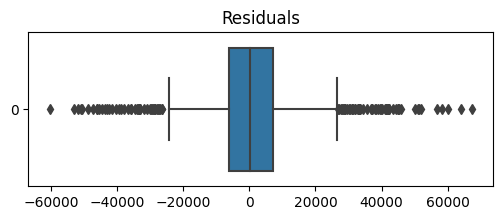

In [ ]:
analyze_model(tree.DecisionTreeRegressor(), train_x, train_y, test_x, test_y)

Mean Error: 12570.551629


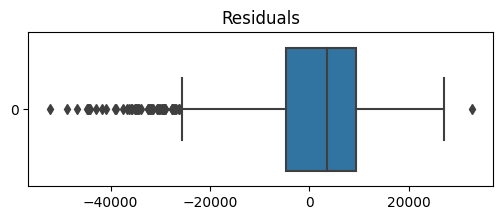

In [ ]:
analyze_model(linear_model.LinearRegression(), train_x, train_y, test_x, test_y)

The models tend to predict a lower value than the actual. This could be caused by the distribution of data.